In [26]:
import itertools
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq
import pmdarima as pm
import seaborn as sns; sns.set()
import statsmodels.api as sm

from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"

warnings.filterwarnings("ignore")

In [27]:
all = query_ticker_data().set_index('date')

In [28]:
apple = all[all['ticker'] == 'AAPL']
netflix = all[all['ticker'] == 'NFLX']
microsoft = all[all['ticker'] == 'MSFT']
amazon = all[all['ticker'] == 'AMZN']
alphabet = all[all['ticker'] == 'GOOGL']
coke = all[all['ticker'] == 'KO']

In [29]:
apple.name = "Apple"
netflix.name = "Netflix"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [30]:
TARGET_DF = netflix

In [31]:
def query_ticker_data():
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_by_month`
        ORDER BY date
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df


def test_p_value(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')


def stationarity_test(data):
    test_p_value(data['volume_weighted_average_price'])


def plot_history(data):
    plt.figure(figsize=(20, 10), dpi=150)
    plt.plot(data.index, data.volume_weighted_average_price, color='tab:blue')
    plt.gca().set(title=f'{data.name} Stock History', xlabel='Date', ylabel='$')
    plt.show()


def plot_trend(data):
    data['volume_weighted_average_price'].rolling(12).mean().plot(label='12 SMA',figsize=(16,8))
    data['volume_weighted_average_price'].rolling(12).std().plot(label='12 STD')
    data['volume_weighted_average_price'].plot()
    plt.legend()


def seasonal_decomposition(data):
    result_add = seasonal_decompose(data.volume_weighted_average_price, model='additive', extrapolate_trend='freq', period=12)
    plt.rcParams.update({'figure.figsize': (20, 20)})
    result_add.plot().suptitle('', fontsize=15)
    plt.show()


def acf_pacf(data):
    data['first_diff']=data['volume_weighted_average_price'] - data['volume_weighted_average_price'].shift(1)
    data['second_diff'] = data['first_diff'] - data['first_diff'].shift(1)
    data['seasonal_diff'] = data['volume_weighted_average_price'] - data['volume_weighted_average_price'].shift(12)
    test_p_value(data['first_diff'].dropna())
    test_p_value(data['second_diff'].dropna())
    test_p_value(data['seasonal_diff'].dropna())
    first_diff = plot_acf(data['first_diff'].dropna())
    sec_diff = plot_pacf(data['second_diff'].dropna())


def forecast(ARIMA_model, target_df=TARGET_DF, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(target_df.index[-1] + pd.DateOffset(months=-1), periods = n_periods, freq='MS')


    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(target_df["volume_weighted_average_price"], color='#1f76b4')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Volume Weighted Average Price")
    plt.show()

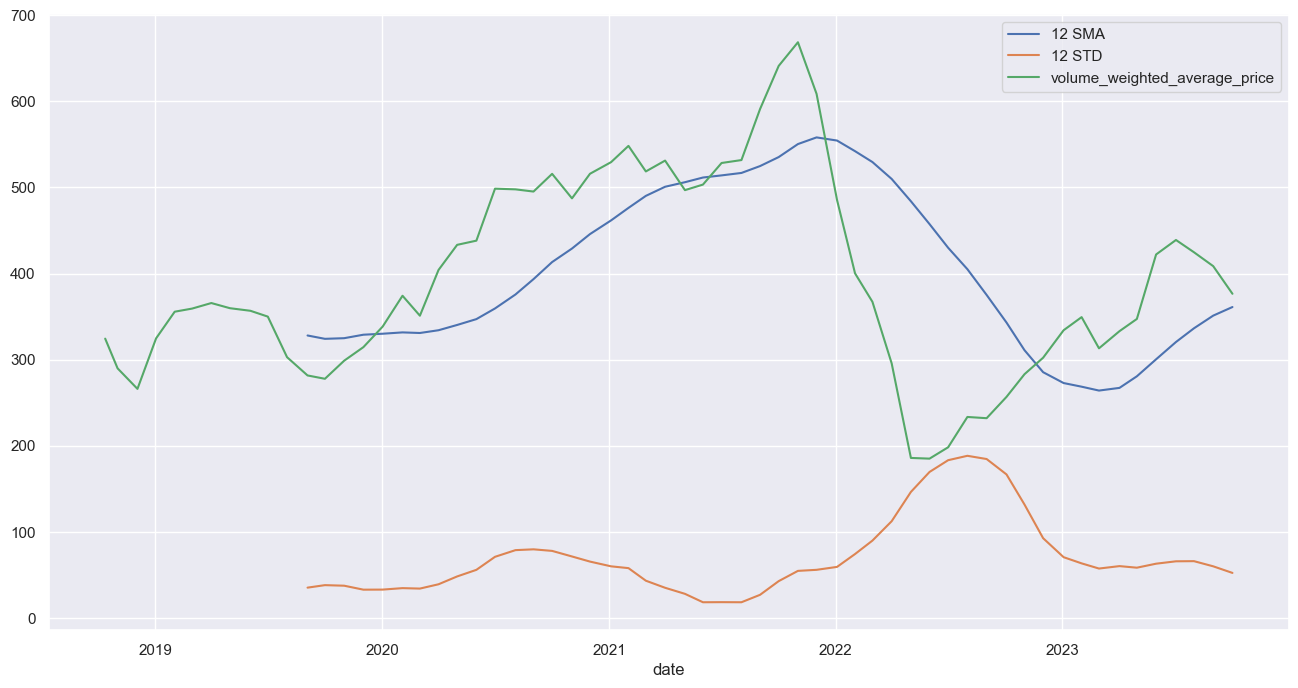

In [32]:
plot_trend(TARGET_DF)

In [33]:
stationarity_test(TARGET_DF)

P-value:  0.16374972648920194
Do not reject null hypothesis, data is not stationary


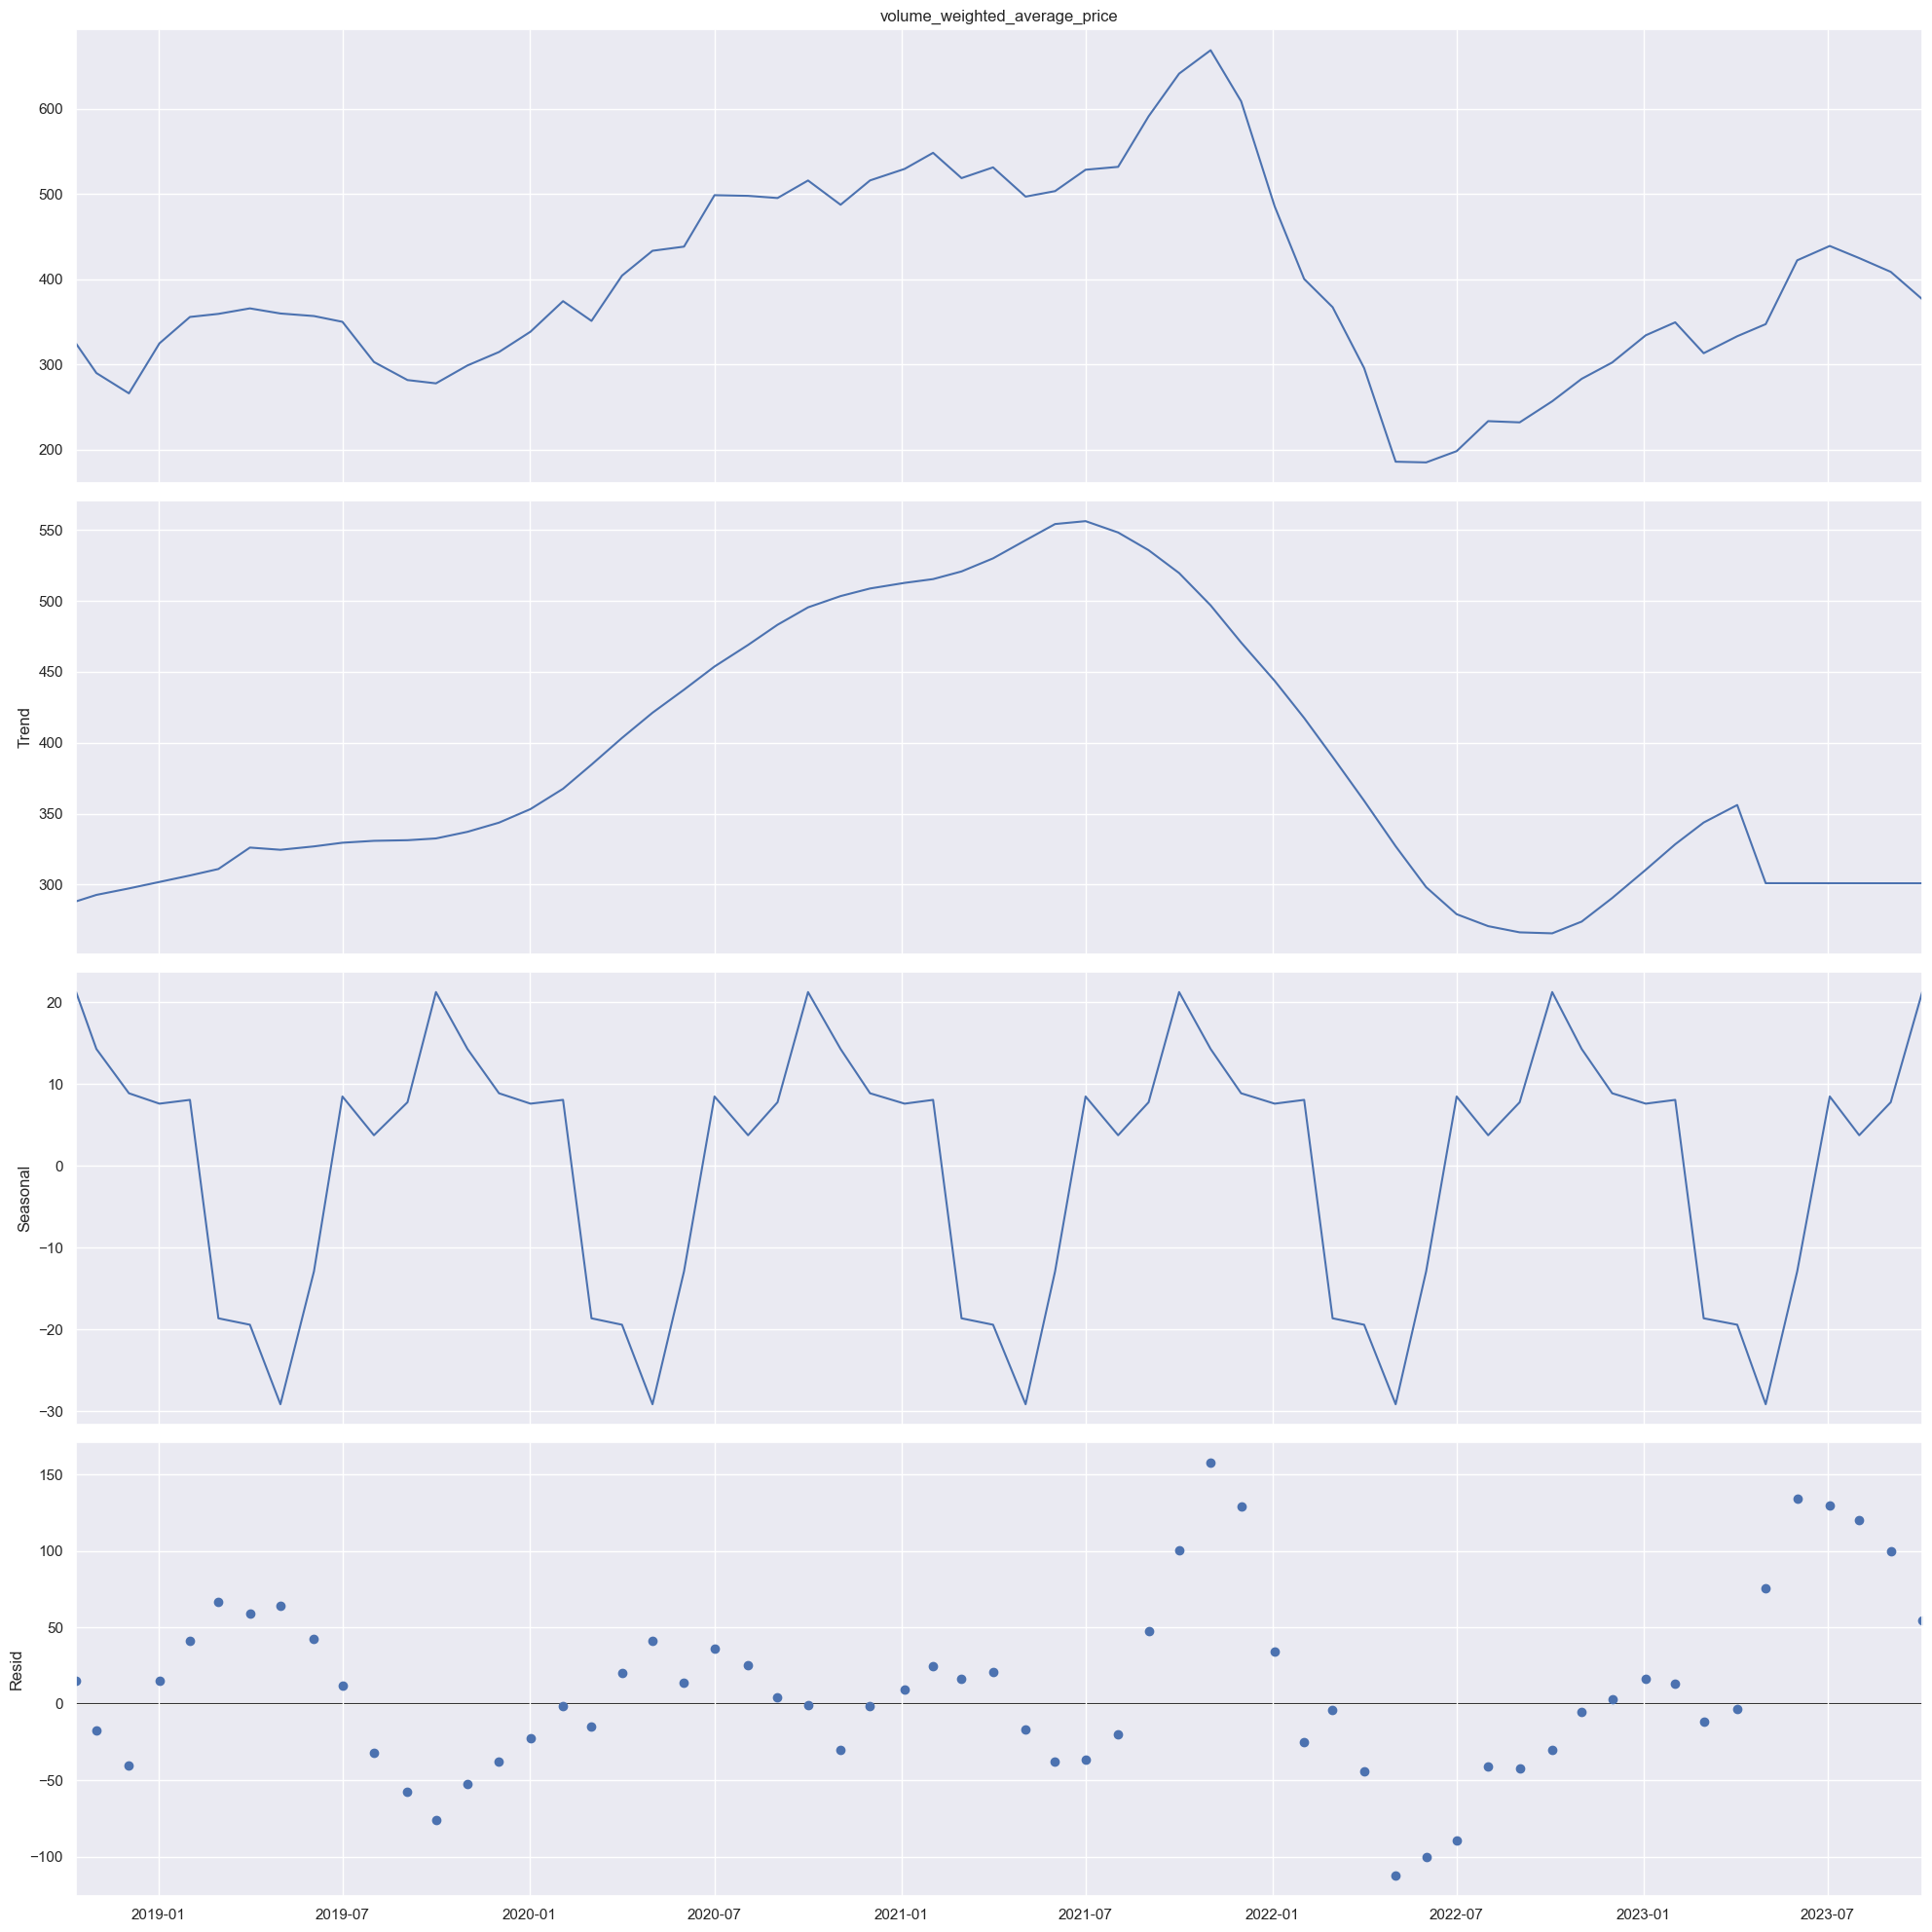

In [34]:
seasonal_decomposition(TARGET_DF)

P-value:  0.00011464661244302552
Reject null hypothesis, data is stationary
P-value:  3.073166616646286e-17
Reject null hypothesis, data is stationary
P-value:  0.2794956591579656
Do not reject null hypothesis, data is not stationary


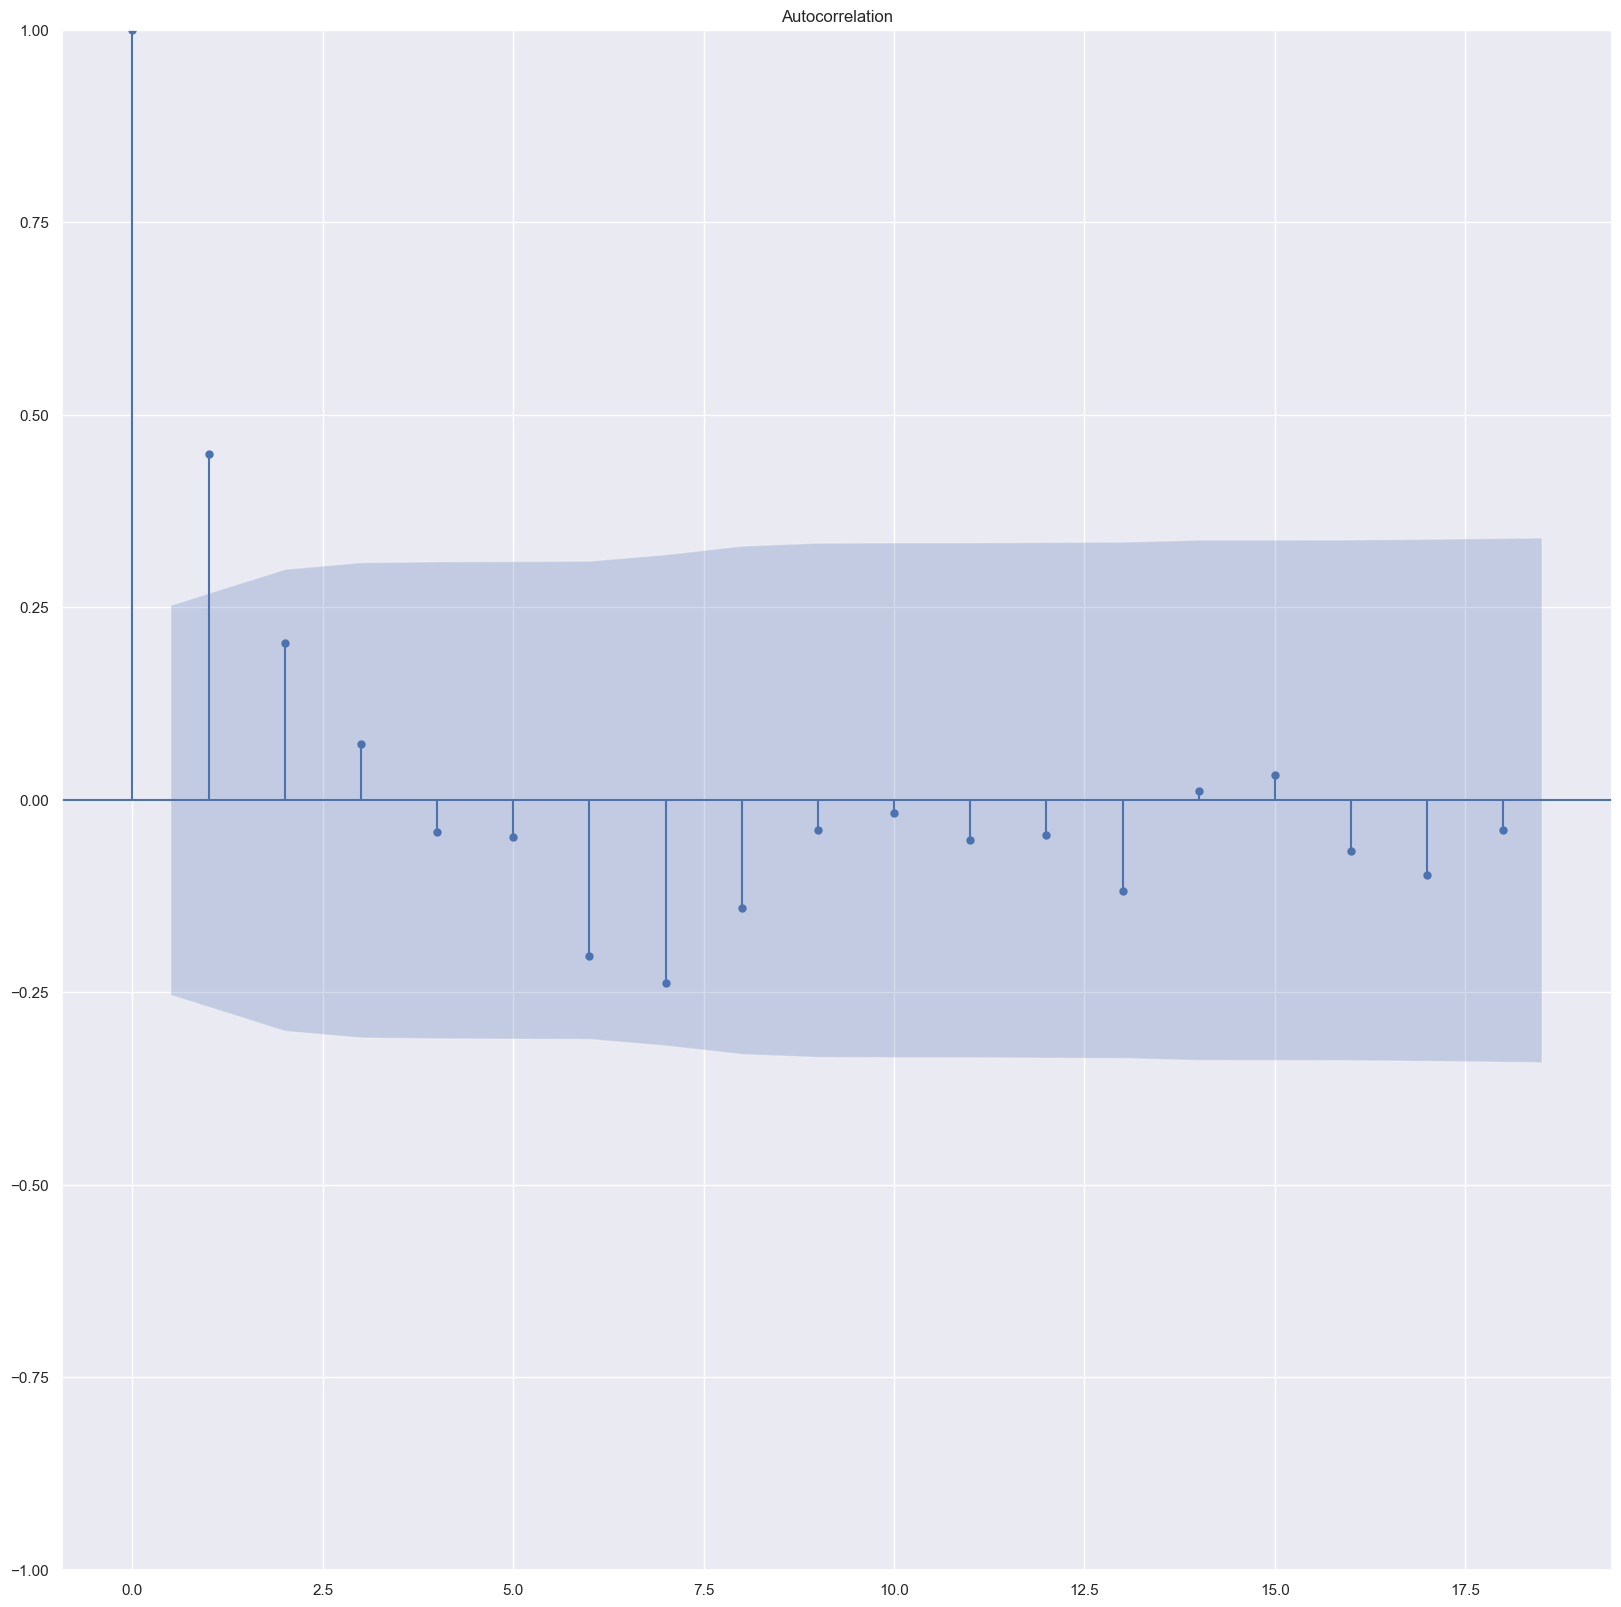

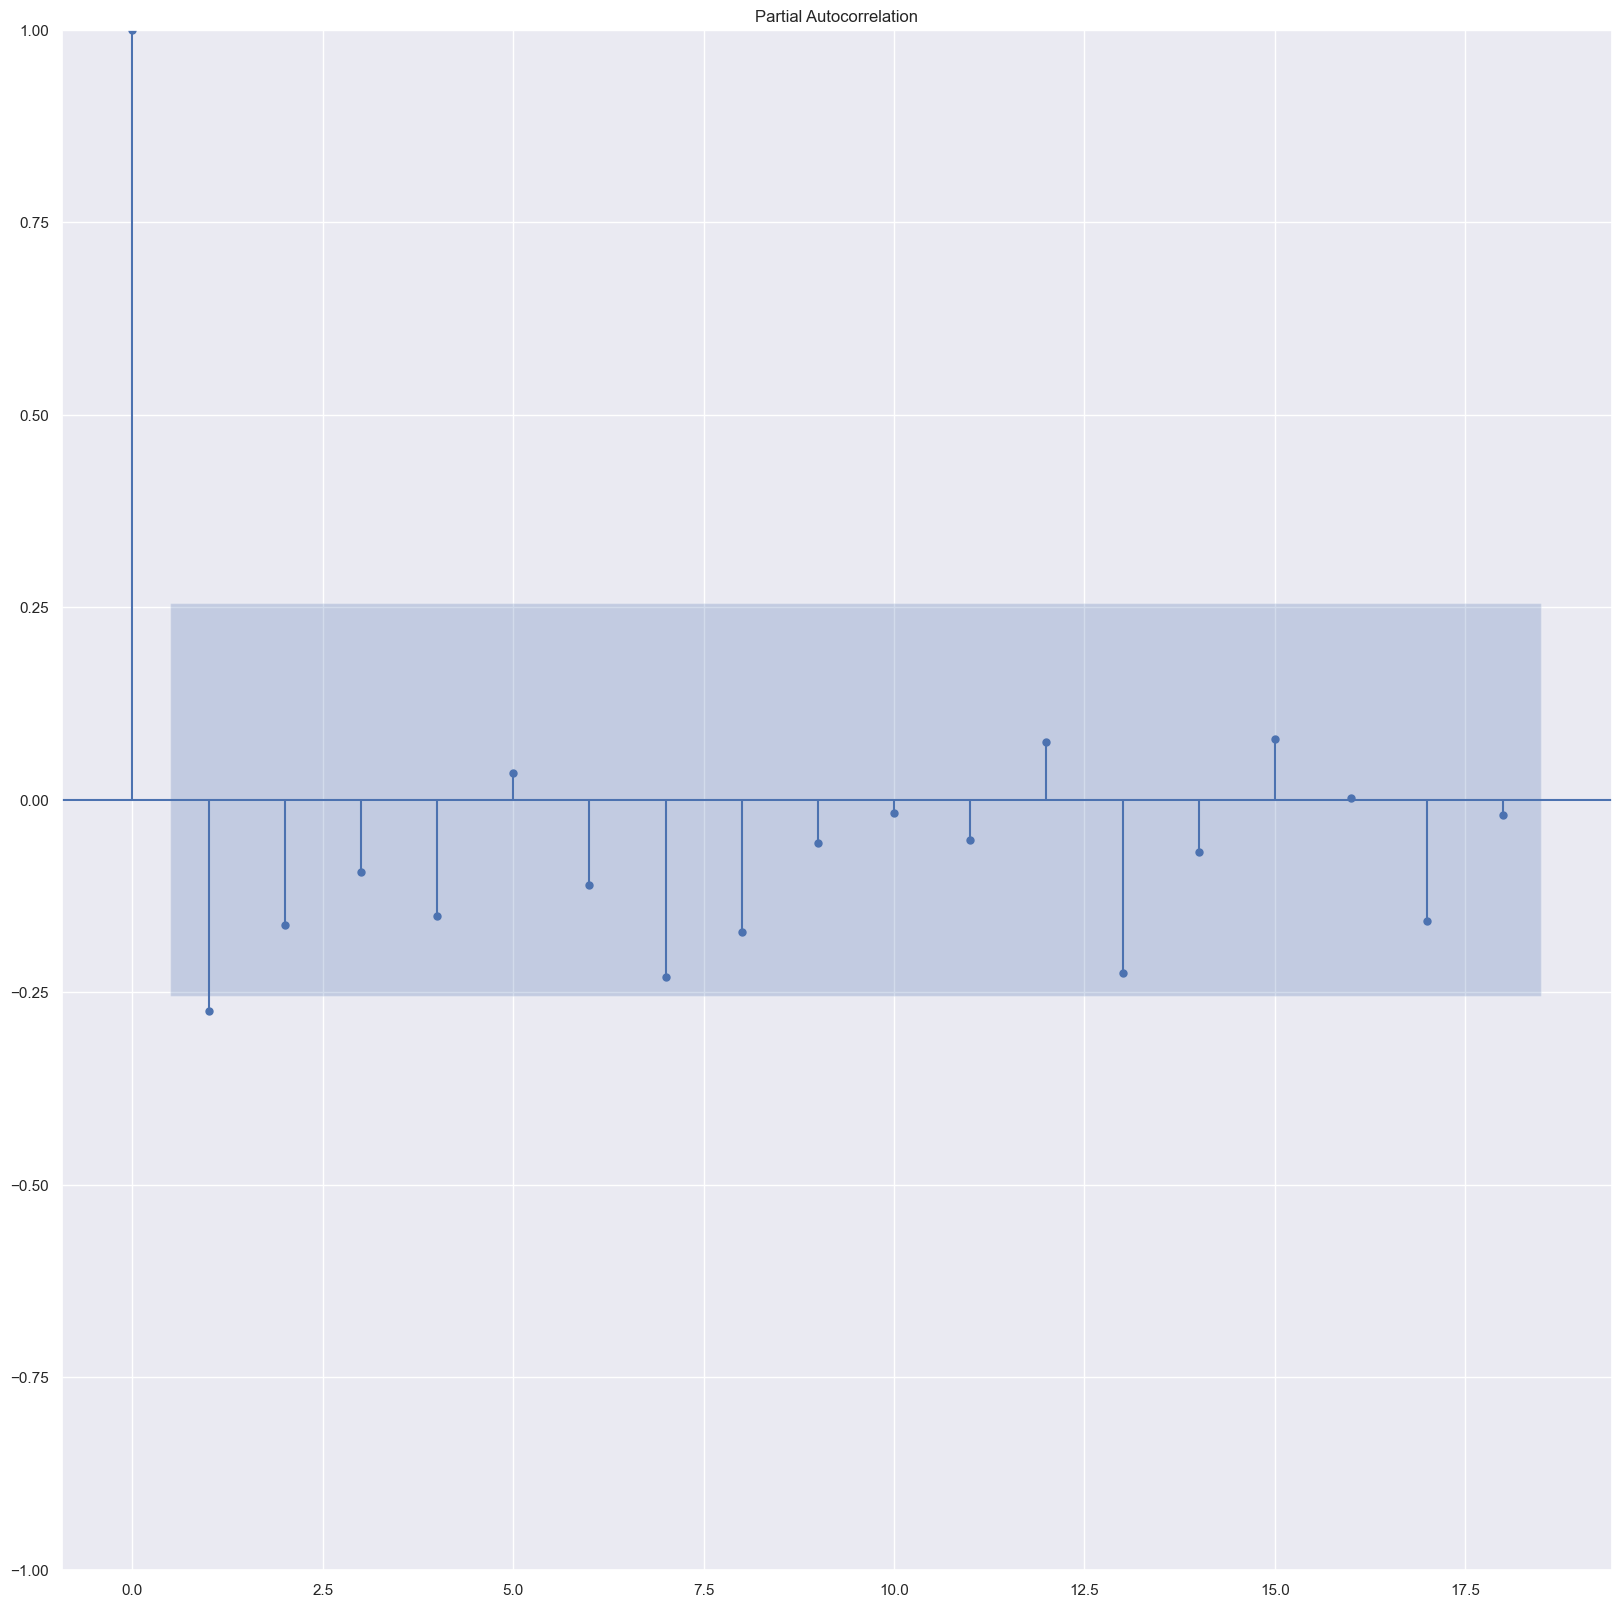

In [35]:
acf_pacf(TARGET_DF)   # p, q

In [36]:
SARIMA_model =  pm.auto_arima(TARGET_DF["volume_weighted_average_price"], start_p=0, start_q=0,
                         test='adf',
                         d=None,
                         max_p=2, max_q=2,
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, start_Q = 0,
                         seasonal=True, #set to seasonal
                         max_P=2, max_Q=2, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [22]:
SARIMA_model

ARIMA(order=(0, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

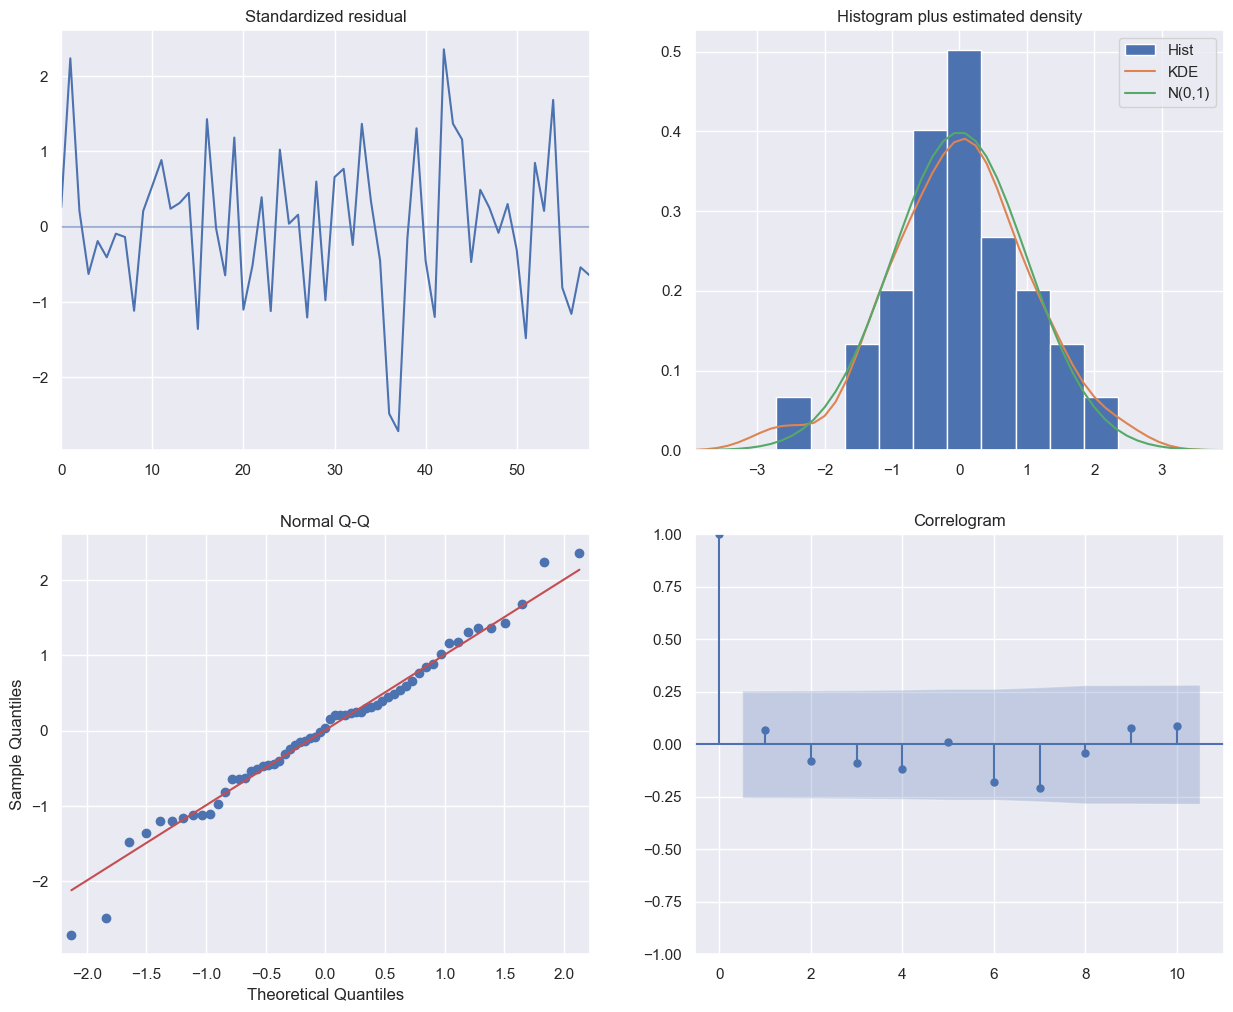

In [37]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

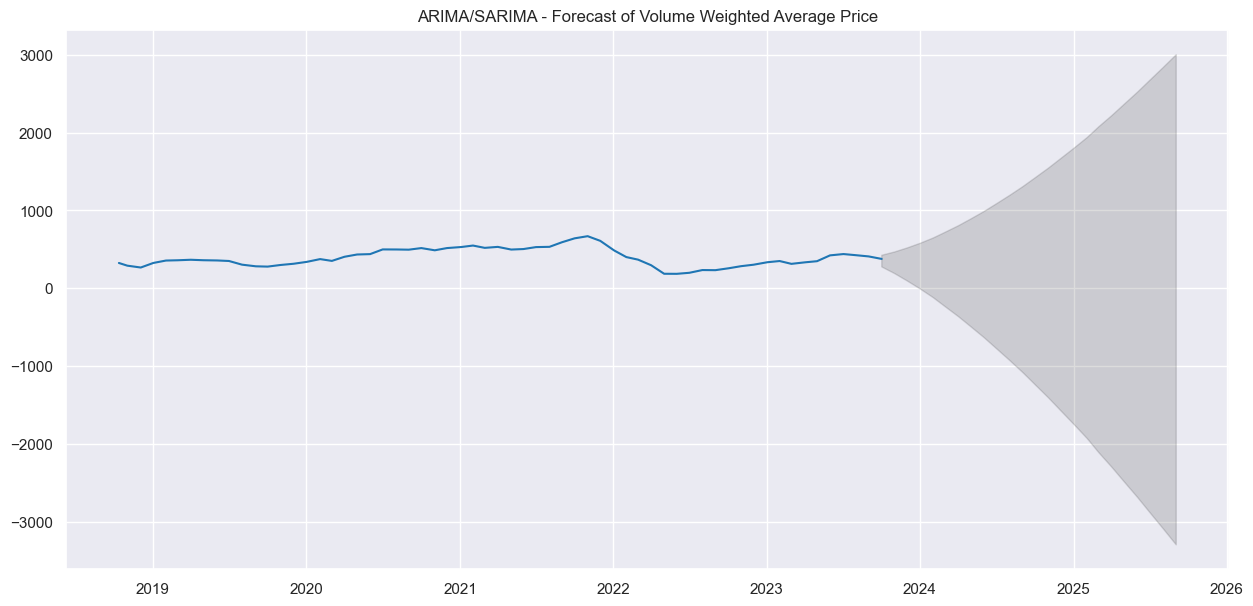

In [38]:
forecast(SARIMA_model, TARGET_DF, 24)